# **Fares Ahmed Moustafa**
## Apply K-means with different K tuning methods

In [9]:
# Cell 1 — imports + load iris
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
df = X.copy()
df['target'] = y

print("shape:", df.shape)
print(df.head().to_string(index=False))


shape: (150, 5)
 sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  target
               5.1               3.5                1.4               0.2       0
               4.9               3.0                1.4               0.2       0
               4.7               3.2                1.3               0.2       0
               4.6               3.1                1.5               0.2       0
               5.0               3.6                1.4               0.2       0


In [2]:
# Cell 2 — quick EDA
print("missing:", df.isna().sum().to_dict())
print("duplicates:", int(df.duplicated().sum()))
print("class counts:", df['target'].value_counts().sort_index().to_dict())
print("\nsummary:\n", df.describe().T)

missing: {'sepal length (cm)': 0, 'sepal width (cm)': 0, 'petal length (cm)': 0, 'petal width (cm)': 0, 'target': 0}
duplicates: 1
class counts: {0: 50, 1: 50, 2: 50}

summary:
                    count      mean       std  min  25%   50%  75%  max
sepal length (cm)  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9
sepal width (cm)   150.0  3.057333  0.435866  2.0  2.8  3.00  3.3  4.4
petal length (cm)  150.0  3.758000  1.765298  1.0  1.6  4.35  5.1  6.9
petal width (cm)   150.0  1.199333  0.762238  0.1  0.3  1.30  1.8  2.5
target             150.0  1.000000  0.819232  0.0  0.0  1.00  2.0  2.0


In [3]:
# Cell 3 — preprocessing: scale features
from sklearn.preprocessing import StandardScaler
features = data.feature_names
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
print(X_scaled_df.head().to_string(index=False))

 sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
         -0.900681          1.019004          -1.340227         -1.315444
         -1.143017         -0.131979          -1.340227         -1.315444
         -1.385353          0.328414          -1.397064         -1.315444
         -1.506521          0.098217          -1.283389         -1.315444
         -1.021849          1.249201          -1.340227         -1.315444


In [4]:
# Cell 4 — run KMeans for k=2..10 and collect metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

results = []
labels_store = {}
for k in range(2, 11):
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    labels_store[k] = labels
    results.append((k, km.inertia_, silhouette_score(X_scaled, labels),
                    calinski_harabasz_score(X_scaled, labels),
                    davies_bouldin_score(X_scaled, labels)))

res_df = pd.DataFrame(results, columns=['k','inertia','silhouette','calinski_harabasz','davies_bouldin']).set_index('k')
print(res_df.round(4))

     inertia  silhouette  calinski_harabasz  davies_bouldin
k                                                          
2   222.3617      0.5818           251.3493          0.5933
3   139.8205      0.4599           241.9044          0.8336
4   114.0925      0.3869           207.2659          0.8698
5    90.9275      0.3459           202.9515          0.9483
6    81.5444      0.3171           183.1091          1.0537
7    72.6311      0.3202           173.0519          0.9905
8    62.5406      0.3387           174.3307          0.9150
9    55.1195      0.3424           174.2309          0.9032
10   47.3910      0.3518           181.3875          0.8748


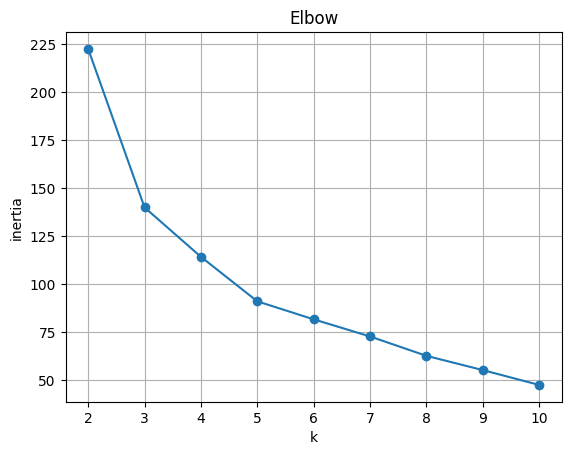

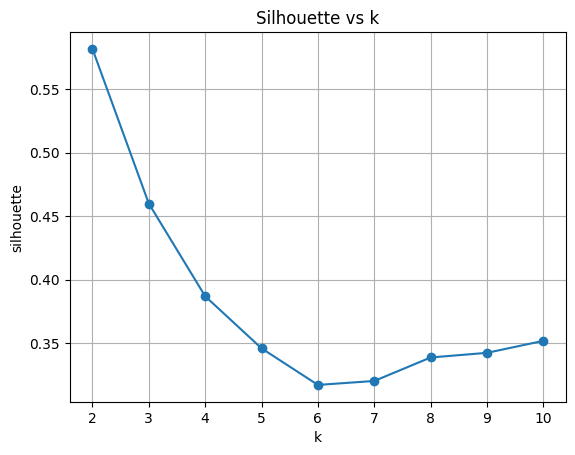

In [5]:
# Cell 5 — elbow + silhouette plots
import matplotlib.pyplot as plt

plt.figure(); plt.plot(res_df.index, res_df['inertia'], marker='o'); plt.xlabel('k'); plt.ylabel('inertia'); plt.title('Elbow'); plt.grid(True); plt.show()
plt.figure(); plt.plot(res_df.index, res_df['silhouette'], marker='o'); plt.xlabel('k'); plt.ylabel('silhouette'); plt.title('Silhouette vs k'); plt.grid(True); plt.show()

best_k = 2 avg_silhouette = 0.5818


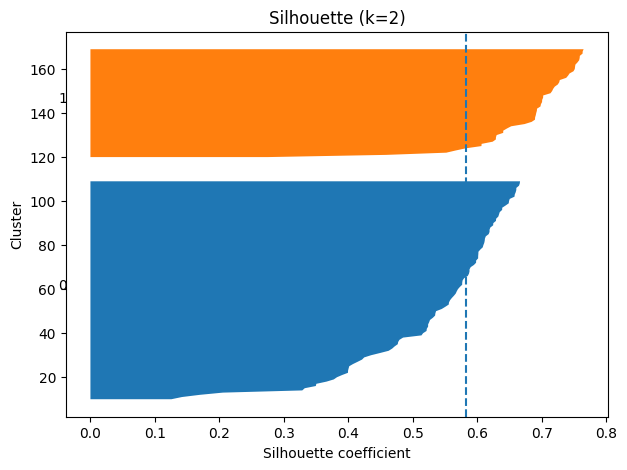

In [6]:
# Cell 6 — silhouette analysis for best k (per-sample plot)
from sklearn.metrics import silhouette_samples
best_k = int(res_df['silhouette'].idxmax())
labels = labels_store[best_k]
sample_sil = silhouette_samples(X_scaled, labels)
print("best_k =", best_k, "avg_silhouette =", sample_sil.mean().round(4))

import numpy as np
fig, ax = plt.subplots(figsize=(7,5))
y_lower = 10
for i in range(best_k):
    ith = sample_sil[labels==i]
    ith.sort()
    size = ith.shape[0]
    if size == 0:
        continue
    y_upper = y_lower + size
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith)
    ax.text(-0.05, y_lower + 0.5*size, str(i))
    y_lower = y_upper + 10
ax.axvline(sample_sil.mean(), linestyle='--')
ax.set_xlabel('Silhouette coefficient'); ax.set_ylabel('Cluster'); ax.set_title(f'Silhouette (k={best_k})')
plt.show()

In [7]:
# Cell 7 — external validation vs true labels
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
conf = pd.crosstab(pd.Series(labels, name='cluster'), y)
purity = conf.max(axis=1).sum() / conf.values.sum()
print(f"ARI={adjusted_rand_score(y, labels):.4f}, NMI={normalized_mutual_info_score(y, labels):.4f}, Purity={purity:.4f}")
print("\nconfusion (cluster x true label):\n", conf)

ARI=0.5681, NMI=0.7337, Purity=0.6667

confusion (cluster x true label):
 target    0   1   2
cluster            
0         0  50  50
1        50   0   0


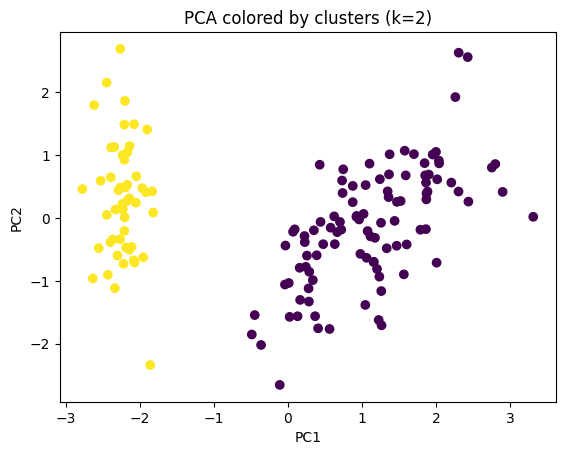

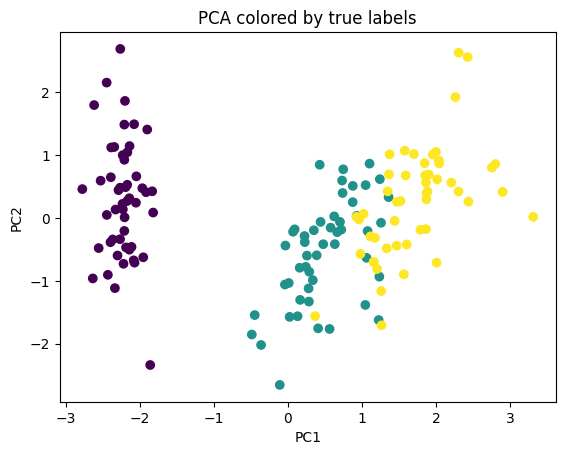

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0              6.262             2.872              4.906             1.676
1              5.006             3.428              1.462             0.246


In [8]:
# Cell 8 — PCA visualization + cluster centers (original scale)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(); plt.scatter(X_pca[:,0], X_pca[:,1], c=labels); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title(f'PCA colored by clusters (k={best_k})'); plt.show()
plt.figure(); plt.scatter(X_pca[:,0], X_pca[:,1], c=y); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA colored by true labels'); plt.show()

km_final = KMeans(n_clusters=best_k, n_init=10, random_state=42).fit(X_scaled)
centers_orig = scaler.inverse_transform(km_final.cluster_centers_)
print(pd.DataFrame(centers_orig, columns=features).round(4))
